In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # matrix construction
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, fbeta_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer

import pandas as pd
import json
import os
import re   

import spacy
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
from ast import literal_eval
from tqdm import tqdm

import sklearn.metrics
import numpy as np


In [2]:
data = '../data/rcatt_training_data_original.csv'

In [3]:
df = pd.read_csv(data).reset_index(drop = True) # transforming into a dataframe

In [4]:
df = df[~df['Text'].duplicated()]

# Visualise Distribution:

In [8]:
%matplotlib inline

In [9]:
Y = df[[col for col in df.columns if col.startswith('TA')]]

<AxesSubplot:>

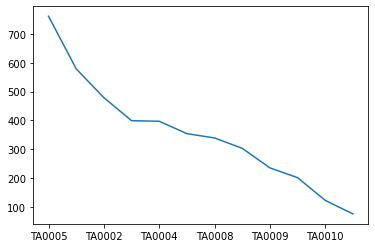

In [10]:
Y.sum(axis=0).sort_values(ascending=False).plot()

In [11]:
Y_tech = df[[col for col in df.columns if col.startswith('T1')]]

<AxesSubplot:>

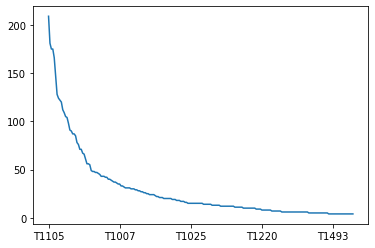

In [12]:
Y_tech.sum(axis=0).sort_values(ascending=False).plot()

# Feature Extraction:

In [36]:
tf_idf = TfidfVectorizer(analyzer = 'word', stop_words='english', lowercase=True, min_df = 2, max_df = 0.99)

data = tf_idf.fit_transform(df['Text'])

X = pd.DataFrame(data.toarray(), columns=tf_idf.get_feature_names()) 

In [37]:
Y = df[[col for col in df.columns if col.startswith('TA')]]

# Naive Bayes: 

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state = 10)

naive_bayes_classifier = OneVsRestClassifier(MultinomialNB())
naive_bayes_classifier.fit(x_train, y_train)


OneVsRestClassifier(estimator=MultinomialNB())

In [22]:
y_pred_proba = pd.DataFrame(naive_bayes_classifier.predict_proba(x_train), columns=y_train.columns)

In [23]:
y_pred = (y_pred_proba > 0.02).astype(int)

In [25]:
f_score_dict = {}
for col in y_test.columns:
    print(col)
    f_score_dict[col] = fbeta_score(y_train[col], y_pred[col],beta=0.5)
    print(classification_report(y_train[col], y_pred[col]))

TA0006
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       812
           1       0.58      0.21      0.31       214

    accuracy                           0.80      1026
   macro avg       0.70      0.58      0.60      1026
weighted avg       0.77      0.80      0.76      1026

TA0002
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       680
           1       0.48      0.90      0.63       346

    accuracy                           0.64      1026
   macro avg       0.70      0.70      0.64      1026
weighted avg       0.77      0.64      0.64      1026

TA0040
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       971
           1       0.00      0.00      0.00        55

    accuracy                           0.95      1026
   macro avg       0.47      0.50      0.49      1026
weighted avg       0.90      0.95      0.92      1026

In [26]:
y_pred_proba = pd.DataFrame(naive_bayes_classifier.predict_proba(x_test), columns=y_test.columns)

In [27]:
y_pred = (y_pred_proba > 0.005).astype(int) # probability of report being part of the tactic

In [28]:
f_score_dict = {}
for col in y_test.columns:
    print(col)
    f_score_dict[col] = fbeta_score(y_test[col], y_pred[col],beta=0.5)
    print(classification_report(y_test[col], y_pred[col]))

TA0006
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       352
           1       0.25      0.31      0.28        89

    accuracy                           0.67       441
   macro avg       0.53      0.54      0.53       441
weighted avg       0.70      0.67      0.68       441

TA0002
              precision    recall  f1-score   support

           0       0.94      0.25      0.40       308
           1       0.36      0.96      0.52       133

    accuracy                           0.47       441
   macro avg       0.65      0.61      0.46       441
weighted avg       0.76      0.47      0.44       441

TA0040
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       421
           1       0.00      0.00      0.00        20

    accuracy                           0.95       441
   macro avg       0.48      0.50      0.49       441
weighted avg       0.91      0.95      0.93       441

In [29]:
f_score_dict

{'TA0006': 0.2568807339449541,
 'TA0002': 0.40894568690095856,
 'TA0040': 0.0,
 'TA0003': 0.4862331575864089,
 'TA0004': 0.3524904214559387,
 'TA0008': 0.2926525529265256,
 'TA0005': 0.5690399137001079,
 'TA0010': 0.09259259259259259,
 'TA0007': 0.3471552555448409,
 'TA0009': 0.15151515151515152,
 'TA0011': 0.36781609195402304,
 'TA0001': 0.14285714285714285}

In [30]:
np.mean(list(f_score_dict.values()))

0.2890148917482203

# SVM: 

In [32]:

sv_classifier = OneVsRestClassifier(LinearSVC(penalty = 'l2', loss = 'squared_hinge', dual = False, max_iter = 1000, class_weight = 'balanced', random_state=42), n_jobs = 1)
sv_classifier.fit(x_train, y_train)


OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced', dual=False,
                                        random_state=42),
                    n_jobs=1)

In [33]:
y_pred = pd.DataFrame(sv_classifier.predict(x_train), columns=y_train.columns)

In [34]:
f_score_dict = {}
for col in y_test.columns:
    print(col)
    f_score_dict[col] = fbeta_score(y_train[col], y_pred[col],beta=0.5)
    print(classification_report(y_train[col], y_pred[col]))

TA0006
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       812
           1       0.92      1.00      0.96       214

    accuracy                           0.98      1026
   macro avg       0.96      0.99      0.97      1026
weighted avg       0.98      0.98      0.98      1026

TA0002
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       680
           1       0.96      0.98      0.97       346

    accuracy                           0.98      1026
   macro avg       0.97      0.98      0.98      1026
weighted avg       0.98      0.98      0.98      1026

TA0040
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       971
           1       0.89      1.00      0.94        55

    accuracy                           0.99      1026
   macro avg       0.94      1.00      0.97      1026
weighted avg       0.99      0.99      0.99      1026

In [35]:
y_pred = pd.DataFrame(sv_classifier.predict(x_test), columns=y_test.columns)

In [36]:
f_score_dict = {}
for col in y_test.columns:
    print(col)
    f_score_dict[col] = fbeta_score(y_test[col], y_pred[col],beta=0.5)
    print(classification_report(y_test[col], y_pred[col]))

TA0006
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       352
           1       0.54      0.43      0.48        89

    accuracy                           0.81       441
   macro avg       0.70      0.67      0.68       441
weighted avg       0.80      0.81      0.80       441

TA0002
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       308
           1       0.70      0.74      0.72       133

    accuracy                           0.83       441
   macro avg       0.79      0.80      0.80       441
weighted avg       0.83      0.83      0.83       441

TA0040
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       421
           1       0.69      0.55      0.61        20

    accuracy                           0.97       441
   macro avg       0.83      0.77      0.80       441
weighted avg       0.97      0.97      0.97       441

In [38]:
np.mean(list(f_score_dict.values()))

0.5973736563384233